In [11]:
import torch
import subprocess
import re
import matplotlib.pyplot as plt
from pprint import pprint
import librosa
from IPython.display import Audio



# Load Silero VAD model
USE_ONNX = False  # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                            #   force_reload=True,
                              onnx=USE_ONNX)

(get_speech_timestamps,
 save_audio,
 read_audio,
 _,
 collect_chunks) = utils

target_sampling_rate = 16000

audio_path = "/Users/yash/Desktop/yash-mtp/datasets/audios/B038.wav"
ref_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE.rttm"
sys_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE_sys.rttm"

Using cache found in /Users/yash/.cache/torch/hub/snakers4_silero-vad_master


In [12]:
def voice_activity_detection_silero(audio_file, sampling_rate):
    # Read audio file
    audio_data = read_audio(audio_file, sampling_rate=sampling_rate)

    # Get speech timestamps using Silero VAD model
    speech_timestamps =  get_speech_timestamps(audio_data, model, sampling_rate=target_sampling_rate)

    # Construct a list of voice segments and a dictionary containing start and end times
    voice_segments = []
    voice_segments_dict = {}
    for i, timestamp in enumerate(speech_timestamps):
        if isinstance(timestamp, int):
            # If the timestamp is an integer, treat it as the start time of a segment
            start_time = timestamp / sampling_rate
            end_time = start_time  # Set end time equal to start time
            duration = 0  # Duration is 0 for single point
        else:
            # If the timestamp is a dictionary, extract start and end times
            start_time = timestamp['start'] / sampling_rate
            end_time = timestamp['end'] / sampling_rate
            duration = end_time - start_time
        
        voice_segments.append((start_time, end_time, duration))
        voice_segments_dict[f"segment_{i+1}"] = {"start": start_time, "end": end_time}

    return voice_segments, voice_segments_dict, speech_timestamps


Original sampling Rate:  16000
[(1.154, 1.534, 0.3800000000000001),
 (1.826, 22.206, 20.38),
 (22.85, 31.678, 8.828),
 (31.842, 45.662, 13.82),
 (47.65, 51.39, 3.740000000000002),
 (51.842, 60.798, 8.956000000000003),
 (61.058, 69.63, 8.571999999999996)]
{'segment_1': {'end': 1.534, 'start': 1.154},
 'segment_2': {'end': 22.206, 'start': 1.826},
 'segment_3': {'end': 31.678, 'start': 22.85},
 'segment_4': {'end': 45.662, 'start': 31.842},
 'segment_5': {'end': 51.39, 'start': 47.65},
 'segment_6': {'end': 60.798, 'start': 51.842},
 'segment_7': {'end': 69.63, 'start': 61.058}}


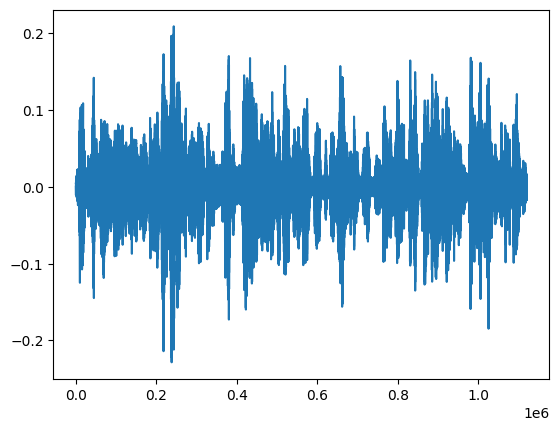

In [13]:
speech, sr = librosa.load(audio_path, sr=target_sampling_rate)
plt.plot(speech)
print("Original sampling Rate: ",sr)
voice_segments, voice_segments_dict , speech_timestamps= voice_activity_detection_silero(audio_path, sampling_rate=target_sampling_rate)
pprint(voice_segments)
pprint(voice_segments_dict)

# Merge all speech chunks into one audio file and save it
wav = read_audio(audio_path, sampling_rate=target_sampling_rate)
speech_audio = collect_chunks(speech_timestamps, wav)
save_audio('/Users/yash/Desktop/yash-mtp/datasets/only_speech.wav', speech_audio, sampling_rate=target_sampling_rate)

# Display the audio with only speech
Audio('/Users/yash/Desktop/yash-mtp/datasets/only_speech.wav')

In [26]:

sys_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE_sys.rttm"

def read_rttm(file_path):
    rttm_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                start = float(parts[3])
                duration = float(parts[4])
                rttm_data[(start, duration)] = parts[7]
    return rttm_data

rttm_data = read_rttm(sys_rttm)
arr = []
arr2 = []
for voice_segment in voice_segments:
    if len(arr) > 0:
        x = arr[len(arr) - 1] + voice_segment[2]
    else:
        x = voice_segment[2]
    arr.append(x)
    arr2.append([voice_segment[0], voice_segment[1]])
# now we have the array, we just need to binary search into it.

# using binary search
def binary_search(arr, x):
    ans = len(arr) - 1
    left, right = 0, len(arr) - 1

    while left <= right:
        mid = left + (right - left) // 2
        
        # Check if x is present at mid
        if arr[mid] == x:
            return mid
        
        # If x is greater, ignore left half
        elif arr[mid] < x:
            left = mid + 1
        
        # If x is smaller, ignore right half
        else:
            ans = mid
            right = mid - 1

    # If we reach here, the element was not present
    return ans

ansarr = []
for key, value in rttm_data.items():
    start, duration = key
    finalpoint = start + duration
    language = value
    startindex = binary_search(arr, start)
    diffvalueStart = arr[startindex] - start
    startpoint = arr2[startindex][1] - diffvalueStart 
    endindex = binary_search(arr, finalpoint)
    diffvalueEnd = arr[endindex] - finalpoint
    endpoint = arr2[endindex][1] - diffvalueEnd
    ansarr.append([startpoint, endpoint]) 
print(ansarr)
diffvaluearr = []
for val in ansarr:
    diffvaluearr.append(val[1] - val[0])
print(diffvaluearr)

[[1.154, 11.196000000000002], [11.196000000000002, 12.446000000000002], [12.446000000000002, 16.196], [16.196, 18.196], [18.196, 19.696], [19.696, 23.090000000000003], [23.090000000000003, 58.443999999999996], [58.443999999999996, 60.443999999999996], [60.443999999999996, 75.02399999999999]]
[10.042000000000002, 1.25, 3.75, 2.0, 1.5, 3.394000000000002, 35.35399999999999, 2.0, 14.579999999999991]


In [22]:
def update_rttm(file_path, new_arr2, output_file_path):
    """
    Update start and duration values in an RTTM file and write to a new file.

    Parameters:
        file_path (str): The path of the input RTTM file.
        new_arr2 (list of lists): List of lists containing updated start and duration pairs.
        output_file_path (str): The path of the output file to write the updated content.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    updated_lines = []
    for line, (start, duration) in zip(lines, new_arr2):
        print(line)
        parts = line.strip().split()
        parts[3] = "{:.3f}".format(start)  # Update start
        parts[4] = "{:.3f}".format(duration)  # Update duration
        updated_line = ' '.join(parts) + '\n'
        updated_lines.append(updated_line)
        print("updated: ",updated_line)
    with open(output_file_path, 'w') as f:
        f.writelines(updated_lines)

# Example usage:
input_file_path = sys_rttm

output_file_path = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE_dummy.rttm"


update_rttm(input_file_path, ansarr, output_file_path)
print("Updated RTTM file written to", output_file_path)


LANGUAGE B038 1 0.000 9.750 <NA> <NA> L2 <NA> <NA>

updated:  LANGUAGE B038 1 1.154 11.196 <NA> <NA> L2 <NA> <NA>

LANGUAGE B038 1 9.750 1.250 <NA> <NA> L1 <NA> <NA>

updated:  LANGUAGE B038 1 11.196 12.446 <NA> <NA> L1 <NA> <NA>

LANGUAGE B038 1 11.000 3.750 <NA> <NA> L2 <NA> <NA>

updated:  LANGUAGE B038 1 12.446 16.196 <NA> <NA> L2 <NA> <NA>

LANGUAGE B038 1 14.750 2.000 <NA> <NA> L1 <NA> <NA>

updated:  LANGUAGE B038 1 16.196 18.196 <NA> <NA> L1 <NA> <NA>

LANGUAGE B038 1 16.750 1.500 <NA> <NA> L2 <NA> <NA>

updated:  LANGUAGE B038 1 18.196 19.696 <NA> <NA> L2 <NA> <NA>

LANGUAGE B038 1 18.250 2.750 <NA> <NA> L1 <NA> <NA>

updated:  LANGUAGE B038 1 19.696 23.090 <NA> <NA> L1 <NA> <NA>

LANGUAGE B038 1 21.000 32.750 <NA> <NA> L2 <NA> <NA>

updated:  LANGUAGE B038 1 23.090 58.444 <NA> <NA> L2 <NA> <NA>

LANGUAGE B038 1 53.750 2.000 <NA> <NA> L1 <NA> <NA>

updated:  LANGUAGE B038 1 58.444 60.444 <NA> <NA> L1 <NA> <NA>

LANGUAGE B038 1 55.750 14.320 <NA> <NA> L2 <NA> <NA>

updated:  LA

In [23]:
sys_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE_dummy.rttm"

In [25]:
ref_rttm

'/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE.rttm'

In [24]:
def run_command(command):
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, check=True, text=True)
        return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        return None

# Example command
command = f'python findDER.py -r "{ref_rttm}" -s "{sys_rttm}"'

# Run the command
output = run_command(command)
print(output)

# Extract the 4th integer from the last line of the output
if output:
    lines = output.split('\n')
    last_line = lines[-1].strip()

    # Use regular expression to extract integers
    floats = re.findall(r'-?\d+\.\d+', last_line)

    if len(floats) >= 1:
        der = floats[0]
        print(f"The required DER is : {der}")
    else:
        print("Enable to extract the integers.")
else:
    print("Command execution failed.")


File                DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  ------  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
B038             240.19  75.05            0.38         0.58     0.46             0.04             0.02          1.56          0.89  0.03   0.02
*** OVERALL ***  240.19  75.05            0.38         0.58     0.46             0.04             0.02          1.56          0.89  0.03   0.02
The required DER is : 240.19
